In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c
from scipy.special import jn
import time
import os
import sys
module_directory = r"C:\Users\Davide\Documents\GitHub\Photonics"
if module_directory not in sys.path:
    sys.path.append(module_directory)
import set_plot_params
set_plot_params.set_plot_params()
mpl.rcParams['ytick.right'] = False

In [2]:
def circular_dielectric_rod_2D_FC(eps1, eps2, a, r, G):
    # eps1: dielectric constant of the circular rod 
    # eps2: dielectric constant of the background 
    volume_fraction = np.pi*r**2/a**2
    if np.linalg.norm(G) != 0:
            xi = 2*volume_fraction*(1/eps1 - 1/eps2)*jn(1, np.linalg.norm(G)*r)/(np.linalg.norm(G)*r)
    else:
        xi = volume_fraction*(1/eps1 - 1/eps2) + 1/eps2   

    return xi

def reciprocal_lattice_vectors_2D(d1, d2, theta, N):
    b1 = 2*np.pi/d1*np.array([1, 1/np.tan(theta)])
    b2 = 2*np.pi/(d2*np.sin(theta))*np.array([0, 1])
    G = []
    for h in range(-(N-1), N):
        for k in range(-(N-1), N):
            if abs(h) + abs(k) <= (N-1):
                G.append(h * b1 + k * b2)
    
    return np.array(sorted(G, key=lambda v: np.linalg.norm(v)))

### 2D BANDSTRUCTURE

In [3]:
# set parameters 
dielectric_function = 'circular_rods'
lattice_type = 'square'
if lattice_type == 'oblique':
    d1 = 1e-6
    d2 = d1
    phi = np.pi/4
elif lattice_type == 'rectangular':
    d1 = 1e-6
    d2 = 2e-6
elif lattice_type == 'square':
    d1 = 1e-6
elif lattice_type == 'rhombic':
    d1 = 1e-6
    phi = np.pi/4
elif lattice_type == 'hexagonal':
    d1 = 1e-6

eps1 = 9
eps2 = 1
n_ratios = 1
ratios = np.linspace(0.4, 0.5, n_ratios)

Nk = 100
N = 4

threshold = 0.01
show_bands = 8

eta = 0.003
n_omega = 1000

Execution time of the for loop: 5.585492 seconds


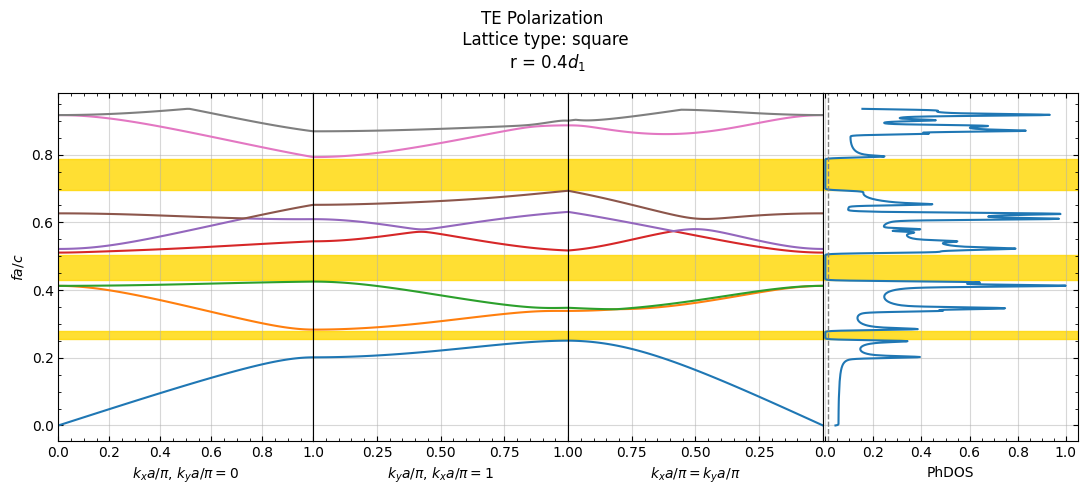

Execution time of the for loop: 11.746771 seconds


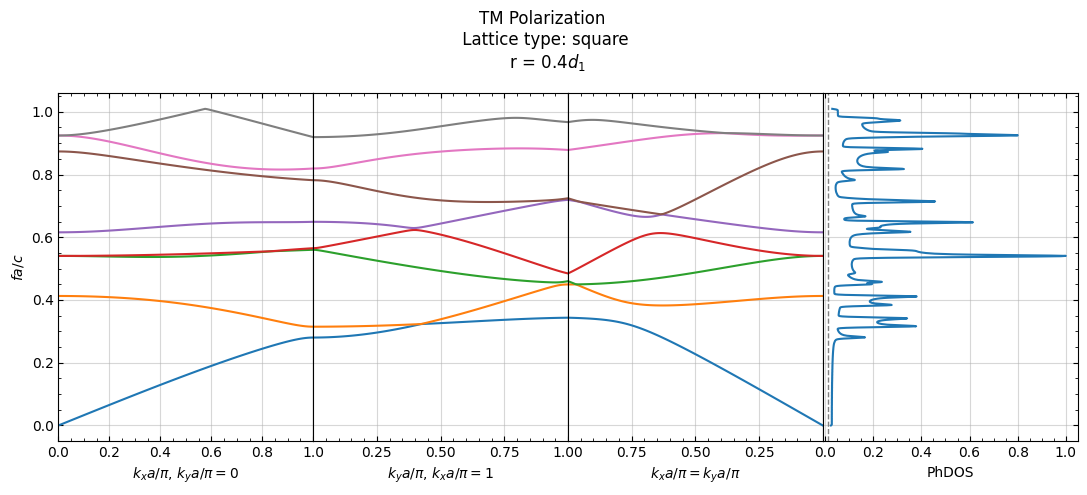

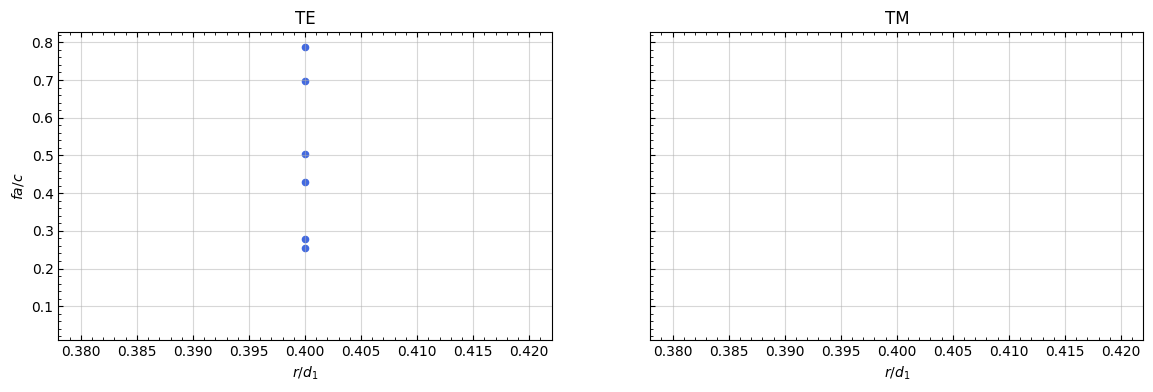

In [14]:
path = os.path.join(dielectric_function, lattice_type)
if not os.path.exists(path):
    os.makedirs(path)

if lattice_type == 'oblique':
    Gs = reciprocal_lattice_vectors_2D(d1, d2, phi, N)
elif lattice_type == 'rectangular':
    phi = np.pi/2
    Gs = reciprocal_lattice_vectors_2D(d1, d2, phi, N)
elif lattice_type == 'square':
    phi = np.pi/2
    Gs = reciprocal_lattice_vectors_2D(d1, d1, phi, N)
    kxs = np.concatenate([np.linspace(0, np.pi/d1, Nk), np.pi/d1*np.ones(Nk), np.linspace(np.pi/d1, 0, Nk)])
    kys = np.concatenate([np.zeros(Nk), np.linspace(0, np.pi/d1, Nk), np.linspace(np.pi/d1, 0, Nk)])
elif lattice_type == 'rhombic':
    Gs = reciprocal_lattice_vectors_2D(d1, d1, phi, N)
elif lattice_type == 'hexagonal':
    phi = 2*np.pi/3
    Gs = reciprocal_lattice_vectors_2D(d1, d1, phi, N)

ks = np.stack((kxs, kys), axis=-1)
Gs_prime = Gs.copy()
dim = int(1+2*N*(N-1))
edges_TE = np.zeros((n_ratios,2*(dim-1)))
edges_TM = np.zeros((n_ratios,2*(dim-1)))
show_bands = np.min([dim, show_bands])
for i1, ratio in enumerate(ratios):
    r = d1*ratio
    start_time = time.perf_counter()
    for T_index in range(2):
        theta = np.zeros((dim, dim), dtype = 'complex')
        omegas = np.zeros((int(ks.size/2), dim), dtype = 'complex')
        for i, k in enumerate(ks): 
            for j1, G in enumerate(Gs):
                G_plus_k = G + k
                for j2, G_prime in enumerate(Gs_prime):
                    delta_G = G - G_prime 
                    if dielectric_function == 'circular_rods':
                        xi = circular_dielectric_rod_2D_FC(eps1, eps2, d1, r, delta_G)
                    if T_index == 0:
                        theta[j1, j2] = xi*np.linalg.norm(G_prime+k)**2 
                    else:
                        theta[j1, j2] = xi*np.dot(G_plus_k,G_prime+k)  
            eigenvalues, eigenvectors = np.linalg.eig(theta)
            sorted_indices = np.argsort(eigenvalues)
            sorted_eigenvalues = eigenvalues[sorted_indices]
            sorted_eigenvectors = eigenvectors[:, sorted_indices]
            omegas[i] = sorted_eigenvalues

        omegas = np.sqrt(np.real(omegas))*c
        normalized_ks = ks*d1/(np.pi)
        normalized_omegas = omegas[:, :show_bands]*d1/(2*np.pi*c)

        omega_min = np.min(normalized_omegas)
        omega_max = np.max(normalized_omegas)
        omega_range = np.linspace(omega_min, omega_max, n_omega)
        D_omega = np.zeros_like(omega_range)
        for omega_k_modes in normalized_omegas.T:
            for omega_k_val in omega_k_modes:
                D_omega += 1/(eta*np.sqrt(np.pi))*np.exp(-(omega_range - omega_k_val)**2/eta**2)
        D_omega = D_omega/np.max(D_omega)

        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        print(f"Execution time of the for loop: {elapsed_time:.6f} seconds")

        lower_edges = []
        upper_edges = []
        for idx in range(0,D_omega.size-1):
            if (D_omega[idx]>= threshold) and (D_omega[idx+1] <= threshold) :
                lower_edges.append(omega_range[idx])
            if (D_omega[idx] < threshold) and (D_omega[idx+1] >= threshold) :
                upper_edges.append(omega_range[idx])

        if T_index == 0:
            edges_TE[i1][:len(lower_edges) + len(upper_edges)] = np.sort(np.concatenate([lower_edges, upper_edges]))
        else:
            edges_TM[i1][:len(lower_edges) + len(upper_edges)] = np.sort(np.concatenate([lower_edges, upper_edges]))

        fig, ax = plt.subplots(ncols=4, figsize = (11,5), sharey=True)

        if T_index == 0:
            T_title = 'TE'
        else:
            T_title = 'TM'
        
        fig.suptitle(f"{T_title} Polarization \n Lattice type: {lattice_type} \n r = ${round(ratio,2)}d_1$")

        ax[0].plot(normalized_ks[:Nk,0], normalized_omegas[:Nk])
        ax[1].plot(normalized_ks[Nk:2*Nk,1], normalized_omegas[Nk:2*Nk])
        ax[2].plot(normalized_ks[2*Nk:,0], normalized_omegas[2*Nk:])
        ax[3].plot(D_omega, omega_range)
        ax[3].axvline(threshold, linestyle = "--", linewidth = 1, color = "grey")

        for i in range(len(lower_edges)):
            ax[0].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
            ax[1].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
            ax[2].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
            ax[3].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
        
        ax[0].set_ylabel("$fa/c$")
        ax[0].set_xlabel(r"$k_xa/\pi$, $k_ya/\pi = 0$")
        ax[1].set_xlabel(r"$k_ya/\pi$, $k_xa/\pi = 1$")
        ax[2].set_xlabel(r"$k_xa/\pi = k_ya/\pi$ ")
        ax[3].set_xlabel("PhDOS")
        ax2 = plt.gca()
        ax[2].set_xlim(ax2.get_xlim()[::-1])

        ax[0].set_xlim(0,1)
        ax[1].set_xlim(0,1)
        ax[2].set_xlim(1,0)
        ax[3].set_xlim(-0.01,None)

        ax[1].tick_params(axis='y', which='both', left=False, right=False)
        ax[2].tick_params(axis='y', which='both', left=False, right=False)
        ax[3].tick_params(axis='y', which='both', left=False, right=False)
        
        ax[1].set_xticks(ax[1].get_xticks()[1:])
        ax[2].set_xticks(ax[2].get_xticks()[1:-1])
        ax[3].yaxis.tick_right() 

        plt.tight_layout()
        plt.subplots_adjust(wspace=0)
        plt.savefig(os.path.join(path, f"bandstructure_a{d1*1e6}um_eps_rod{eps1}_eps_back{eps2}_ratio{ratio}_{T_title}.png"), dpi = 150)
        plt.show()

fig, ax = plt.subplots(ncols=2, figsize = (14,4), sharey=True)
for i in range(2*(dim-1)):
    ax[0].scatter(ratios, edges_TE.T[i], s = 20, color = "royalblue")
    ax[1].scatter(ratios, edges_TM.T[i], s = 20, color = "royalblue")
ax[0].set_ylim(0.01, None)
ax[1].set_ylim(0.01, None)
ax[0].set_xlabel("$r/d_1$")
ax[1].set_xlabel("$r/d_1$")
ax[0].set_ylabel("$fa/c$")
ax[0].set_title("TE")
ax[1].set_title("TM")
plt.savefig(os.path.join(path, f"bandgap_map_a{d1*1e6}um_eps_rod{eps1}_eps_back{eps2}.png"), dpi = 150)
plt.show()

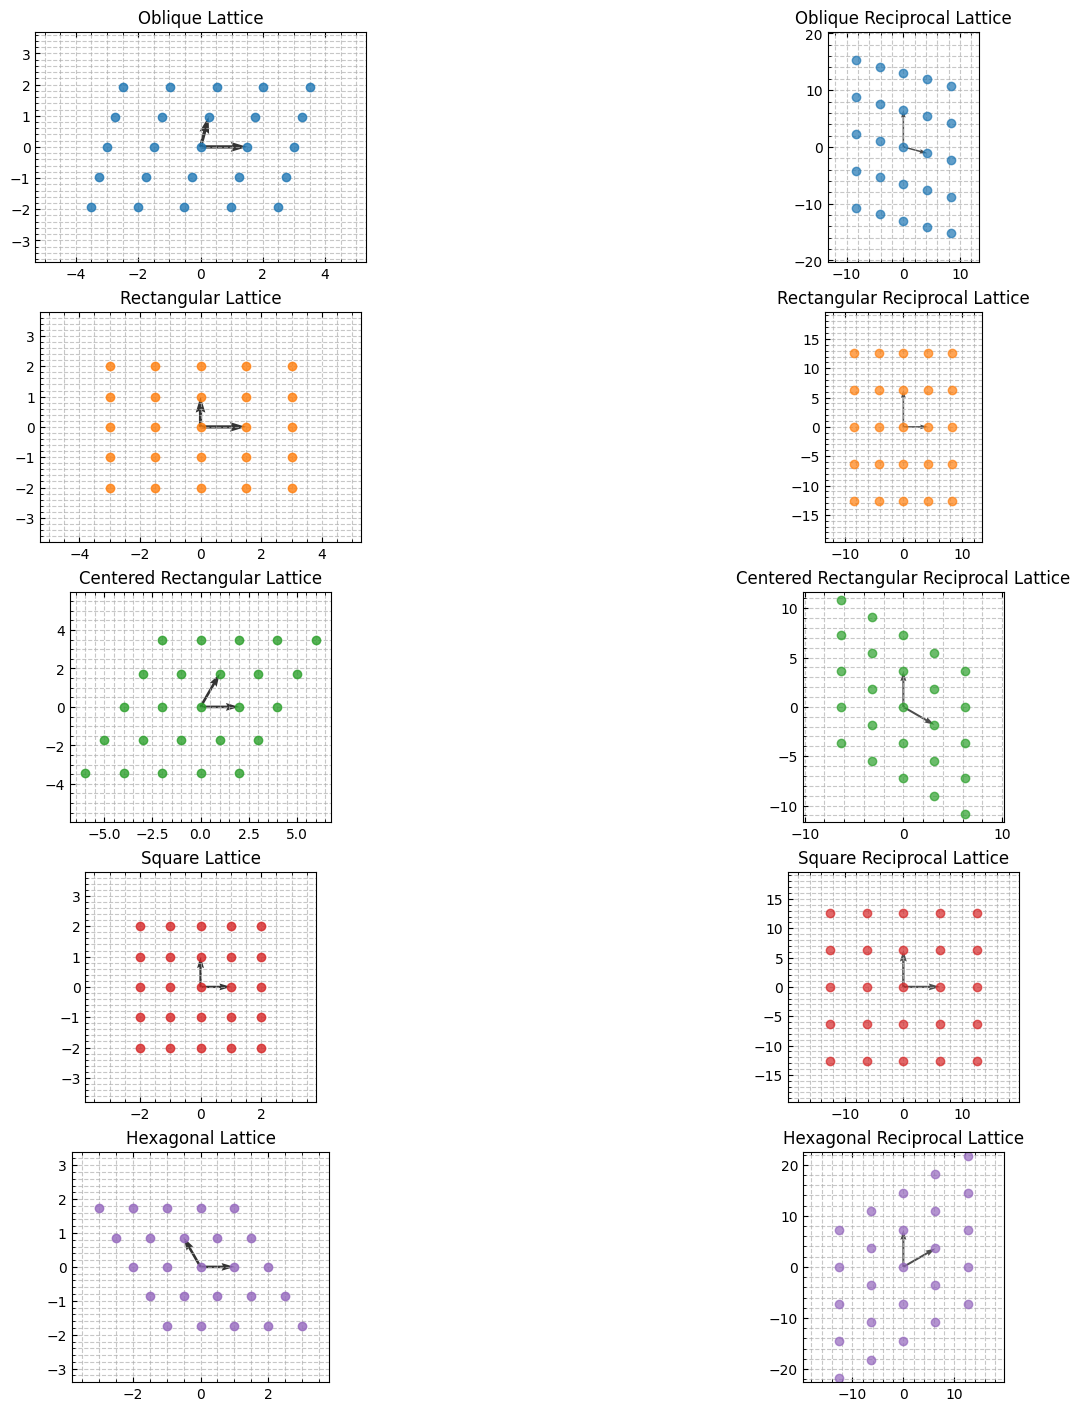

In [5]:
def create_oblique_lattice(a, b, theta):
    a1 = np.array([a, 0])
    a2 = np.array([b * np.cos(np.radians(theta)), b * np.sin(np.radians(theta))])
    return a1, a2

def plot_lattice(a1, a2, title, ax, lattice_color='b', lattice_alpha=0.8, arrow_color='k'):
    # Draw the direct lattice points
    for i in range(-2, 3):
        for j in range(-2, 3):
            point = i * a1 + j * a2
            ax.plot(point[0], point[1], 'o', color=lattice_color, alpha=lattice_alpha)
    # Draw the lattice vectors
    ax.quiver(0, 0, a1[0], a1[1], angles='xy', scale_units='xy', scale=1, color=arrow_color, alpha=lattice_alpha, width=0.01)
    ax.quiver(0, 0, a2[0], a2[1], angles='xy', scale_units='xy', scale=1, color=arrow_color, alpha=lattice_alpha, width=0.01)
    ax.set_title(title, fontsize=12)
    ax.set_aspect('equal')
    ax.grid(True, which='both', linestyle='--', alpha=0.7)

def reciprocal_lattice(a1, a2):
    area = np.cross(a1, a2)
    b1 = 2 * np.pi * np.array([a2[1], -a2[0]]) / area
    b2 = 2 * np.pi * np.array([-a1[1], a1[0]]) / area
    return b1, b2

def set_dynamic_limits(ax, a1, a2):
    # Compute limits based on lattice vectors
    x_max = max(abs(a1[0]), abs(a2[0])) * 3 + 0.8
    y_max = max(abs(a1[1]), abs(a2[1])) * 3 + 0.8
    ax.set_xlim(-x_max, x_max)
    ax.set_ylim(-y_max, y_max)

# Define lattice vectors for different types of lattices
lattices = {
    "Oblique": (1.5, 1.0, 75),
    "Rectangular": (1.5, 1.0, 90),
    "Centered Rectangular": (2.0, 2.0, 60),
    "Square": (1.0, 1.0, 90),
    "Hexagonal": (1.0, 1.0, 120)
}

fig, axs = plt.subplots(len(lattices), 2, figsize=(14, 14), constrained_layout=True)

# Use different colors for each lattice type
colors = plt.cm.tab10.colors[:len(lattices)]

for i, (name, (a, b, theta)) in enumerate(lattices.items()):
    a1, a2 = create_oblique_lattice(a, b, theta)
    b1, b2 = reciprocal_lattice(a1, a2)
    
    # Plot real lattice (lighter color)
    plot_lattice(a1, a2, f"{name} Lattice", axs[i, 0], lattice_color=colors[i], arrow_color='k')
    set_dynamic_limits(axs[i, 0], a1, a2)
    
    # Plot reciprocal lattice (darker color)
    plot_lattice(b1, b2, f"{name} Reciprocal Lattice", axs[i, 1], lattice_color=colors[i], lattice_alpha=0.7, arrow_color='k')
    set_dynamic_limits(axs[i, 1], b1, b2)

plt.show()